In [1]:
import deepdish as dd
from plotnine import *
from matplotlib import pyplot as plt
import numpy as np

In [2]:
null_dist = "output/dnase_null.h5"
true_dist = "output/dnase_true.h5"
bed_file = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/nautilus_runs/K562_02.17.2022_bias_128_4_1234_0.5_fold_0/chrombpnet_model/filtered.peaks.bed"
output_prefix = "output/k562_dnase"
smooth=True
null = dd.io.load(null_dist)

data_full = null["probs"] 
kernel_size = 7
kernel = np.ones(kernel_size) / kernel_size
smooth_data = []
for idx, data in enumerate(data_full):
    data_convolved = np.convolve(data, kernel, mode='valid')
    smooth_data.append(data_convolved)

if smooth: 
    smooth_data = np.array(smooth_data)
else:
    smooth_data = data_full

lowerq = np.quantile(smooth_data,0.01)
upperq = np.quantile(smooth_data,0.99)


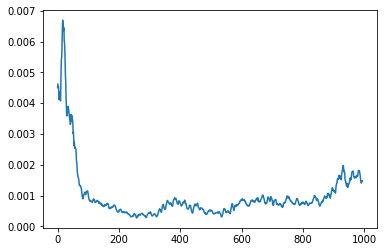

In [3]:
plt.plot(smooth_data[0])

In [4]:
profiles = dd.io.load(true_dist)

In [5]:
data_full = profiles["probs"][0:100000,:]
kernel_size = 7
kernel = np.ones(kernel_size) / kernel_size
smooth_data = []
for idx, data in enumerate(data_full):
    data_convolved = np.convolve(data, kernel, mode='valid')
    smooth_data.append(data_convolved)
    
if smooth: 
    smooth_data = np.array(smooth_data)
else:
    smooth_data = data_full

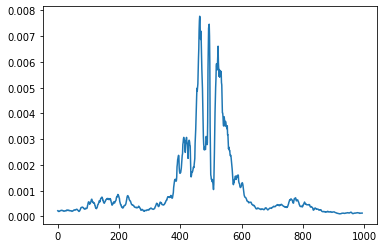

In [6]:
plt.plot(smooth_data[0])

In [7]:
#sig = (smooth_data[0] > upperq) | (smooth_data[0] < lowerq)

sig = smooth_data[0] > upperq


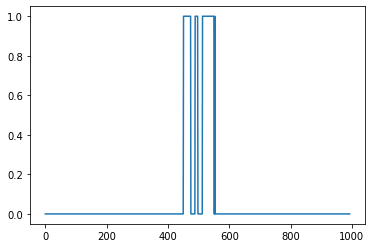

In [8]:
kernel_size = 7
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(sig, kernel, mode='same')
plt.plot(sig)

In [9]:
sig_vals = []
for idx in range(smooth_data.shape[0]):
    sig = (smooth_data[idx] > upperq) | (smooth_data[idx] < lowerq)
    #sig = smooth_data[idx] > upperq 
    
    sig_vals.append(sig)

sig_vals = np.array(sig_vals)

In [10]:
import pandas as pd
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

bedf = pd.read_csv(bed_file, sep='\t', names=NARROWPEAK_SCHEMA)
gm12878_bed = bedf.sort_values('5',ascending = False)

In [11]:
sig_vals.shape

(100000, 994)

In [12]:
def get_regions(regions_bed, width):
    # regions file is assumed to be centered at summit (2nd + 10th column)
    # it is adjusted to be of length seqlen centered at summit

    assert(width%2==0)

    regions = []
    for i, r in regions_bed.iterrows():
        regions.append([r['chr'], r['start'] + r['summit'] - width//2, r['start'] + r['summit'] + width//2, r['start'] + r['summit']])
        

    return regions


In [13]:
gm_bed = get_regions(gm12878_bed.head(100000), width=994)

In [14]:
import bigwig_helper
chrom_sizes = "/mnt/lab_data2/anusri/chrombpnet/reference/chrom.sizes"

gs = bigwig_helper.read_chrom_sizes(chrom_sizes)
bigwig_helper.write_bigwig(sig_vals, 
                           gm_bed, 
                           gs, 
                           output_prefix+"_footprint_sig_100K.bw", 
                           output_prefix+"_footprint_sig_100K.stats.txt", 
                           debug_chr=None, 
                           use_tqdm=True)


100%|██████████| 100000/100000 [01:59<00:00, 839.23it/s]


In [15]:
index = ((gm12878_bed.head(100000)["start"] < 70006) & (gm12878_bed.head(100000)["end"] > 70006)).values

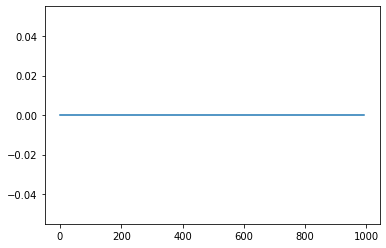

In [16]:
plt.plot(sig_vals[index][0])

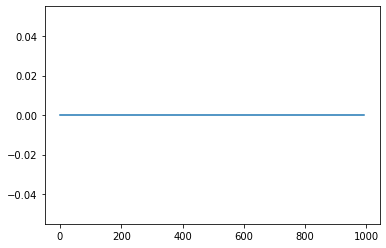

In [17]:
plt.plot(sig_vals[index][1])

In [18]:
gm12878_bed.head(100000)[index]

,chr,start,end,1,2,3,4,5,6,summit
229385,chr1,68963,70035,Peak_66961,1000,.,8.92833,189.89728,187.50624,325
229386,chr1,68963,70035,Peak_93377,1000,.,6.60048,110.44444,108.21621,760


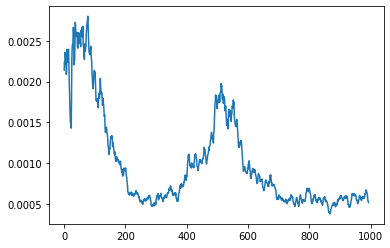

In [19]:
plt.plot(smooth_data[index][1])

In [20]:
print(upperq)

0.0034691155229562105


In [21]:
print(lowerq)

0.00021545542397819059
